## Importing Libraries

In [1]:
# This is used to autoreload updates made in co_mof.py
%load_ext autoreload
%autoreload 2

## Image Processing with RC Thresholding

This script processes an image by converting it to grayscale and applying **Ridler-Calvard (RC) thresholding** for segmentation.

### Steps:
1. **Load Image**: Reads an image from the specified path.
2. **Convert to Grayscale**: Prepares the image for thresholding.
3. **Apply RC Thresholding**: Segments the image using the Ridler-Calvard method, returning:
   - `rc_thresh`: Computed threshold value.
   - `rc_mask`: Binary mask for segmentation.


In [6]:
from co_mof import load_rgb_image, grayscale_image, apply_rc_thresholding

# TODO: use config
# TODO: use script to pull in dataset

# image_path = 'dataset/assets/images/EXP8(SolventVolumes-II-PipetteRepeat)/EXP8COND11II/EXP8_EVOS_20X_001.tif'
image_path = '/Users/kchong99/Co-MOF/examples/images/EXP1_EVOS_20X_031.tif'

# Load and preprocess the image
image = load_rgb_image(image_path)
image_gray = grayscale_image(image)

# Apply Mahotas RC thresholding
rc_thresh, rc_mask = apply_rc_thresholding(image_gray)

## Finding the exact area using the scale bar

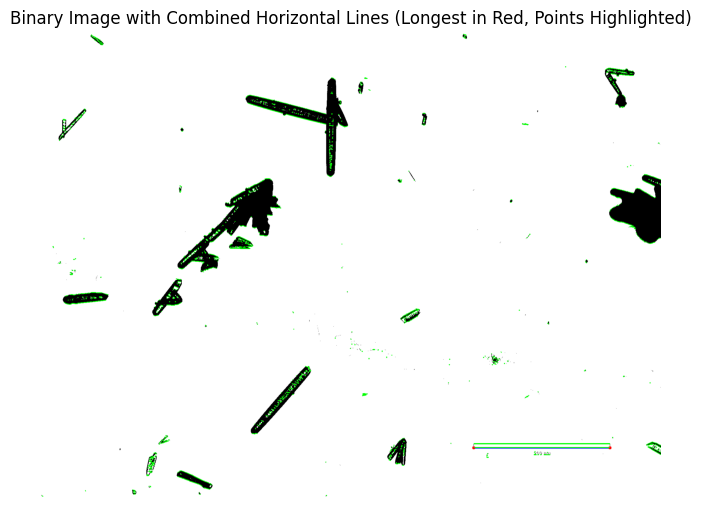

Length of the longest line in pixels: 450.00
Actual length per pixel: 0.4444 micrometers per pixel


In [7]:
from co_mof import detect_horizontal_lines, combine_close_lines, overlay_horizontal_lines, display_overlay
from skimage import measure
import numpy as np


# TODO: what is calculated in this code block that is used in future code blocks? How do these calculations fit into the big picture?
# TODO: calculations should be in functions

# Detect all contours in the binary image using skimage
contours = measure.find_contours(rc_mask, level=0.8)

# Detect horizontal lines in contours
horizontal_lines = detect_horizontal_lines(contours)

# Combine horizontal lines that are close to each other
combined_lines = combine_close_lines(horizontal_lines, pixel_tolerance=5)

# Overlay combined horizontal lines on the binary image and highlight the longest in red
overlay_image, longest_line = overlay_horizontal_lines(rc_mask, combined_lines)

# Display the overlay
display_overlay(overlay_image)

# Assuming the actual length of the longest line is 200 micrometers  # TODO: Why 200?
actual_length_micrometers = 200

# Print details of the longest line  # TODO: should be in function
if longest_line:
    x1, y1, x2, y2 = longest_line
    length_in_pixels = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    length_per_pixel = actual_length_micrometers / length_in_pixels
    print(f"Length of the longest line in pixels: {length_in_pixels:.2f}")
    print(f"Actual length per pixel: {length_per_pixel:.4f} micrometers per pixel")
    
else:
    print("No horizontal lines detected.")
    length_in_pixels = 450
    length_per_pixel = actual_length_micrometers / length_in_pixels

## Morphological Closing on RC Thresholded Image

This script applies **morphological closing** to refine the segmentation from **Ridler-Calvard (RC) thresholding**.

### Steps:
1. **Apply Morphological Closing**:  
   - Enhances the RC thresholded binary image (`rc_mask`) by closing small gaps and noise.
2. **Display Results**:  
   - Shows the original grayscale image, RC thresholded mask, and the morphologically processed image.


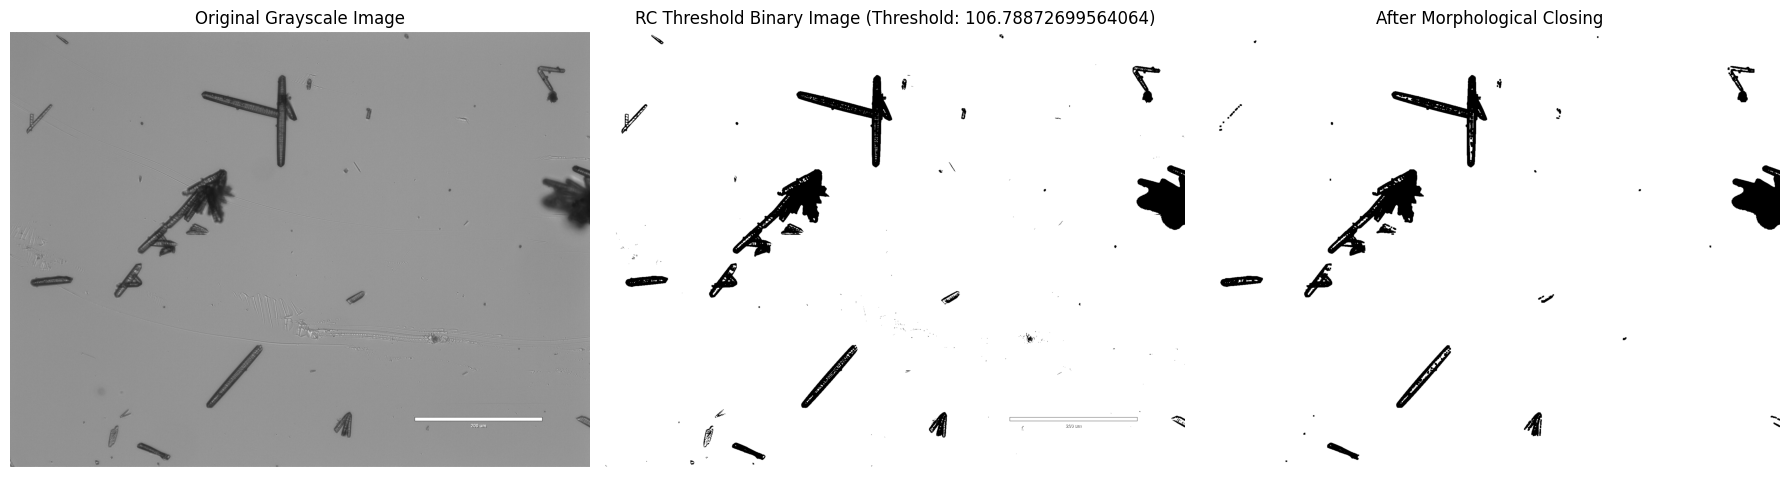

In [8]:
from co_mof import apply_morphological_closing, display_rc_closing_results

# Apply RC thresholding
# rc_thresh, bin_rc = apply_rc_thresholding(image_gray)  # TODO: already did this in cell 1?

# Apply morphological closing on the RC thresholded binary image
closed_image = apply_morphological_closing(rc_mask)

# Display results before and after morphological closing
display_rc_closing_results(image_gray, rc_thresh, rc_mask, closed_image)

## Contour Detection and Filtering

This script detects and filters contours in the binary image.

### Steps:
1. **Find Contours**:  
   - Normalizes `closed_image` and extracts contours using a threshold level of `0.8`.
2. **Filter Contours**:  
   - Removes contours enclosing white regions to focus on relevant structures.
3. **Display Results**:  
   - Overlays the filtered contours onto the processed image.

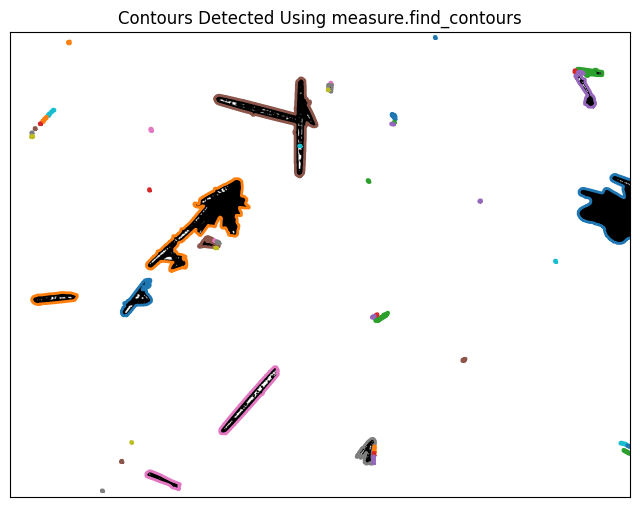

In [9]:
from co_mof import is_contour_enclosing_white_region, normalize_and_find_contours, filter_and_remove_white_region_contours, display_contours

# Example usage:
# Normalize the closing image and find contours
contours = normalize_and_find_contours(closed_image, contour_level=0.8)

# Filter out contours that enclose white regions
contours = filter_and_remove_white_region_contours(closed_image, contours)

# Display the contours on the closing result
display_contours(closed_image, contours)

## Display Contours on Original Image

This script overlays detected contours onto the original microscopic image for better visualization.

### Steps:
1. **Overlay Contours**:  
   - Displays the detected contours overlaid on the original color image for comparison.



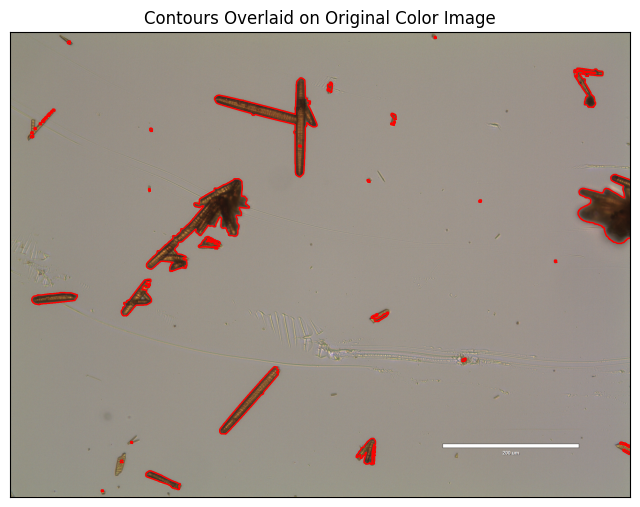

In [10]:
from co_mof import display_contours_on_original_color

# Display the contours overlaid on the original color image
display_contours_on_original_color(image, contours)

## Contour Classification by Convexity and Boundary Detection

## Contour Classification by Convexity

This script classifies detected contours based on their **convexity** and identifies boundary contours.

### Steps:
1. **Classify Contours**:  
   - Segments contours into:
     - **Blue Contours**: Detected isolated crystals and impurities.
     - **Red Contours**: Detected clusters, overlapping crystals, and impurities.
     - **Green Contours**: Identifies contours that enclose other detected contours and classifies them as green countours.
2. **Display Results**:  
   - Overlays classified contours on the original color image for clear visualization.



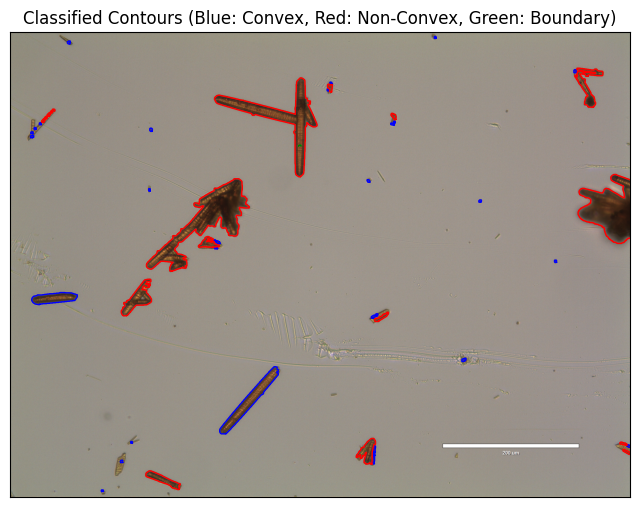

In [12]:
from co_mof import classify_contours_by_convexity, display_classified_contours_on_original_color


# Classify contours based on convexity and identify boundary contours
blue_contours, red_contours, green_contours = classify_contours_by_convexity(image_gray.shape, contours)

# Display the contours overlaid on the original color image, classified by convexity and boundary
display_classified_contours_on_original_color(image, blue_contours, red_contours, green_contours)

# Activated IFF less than 2 Detected Contours

## Overlaying Minimum Bounding Boxes and Calculating Aspect Ratios and Areas 

In [ ]:
from co_mof import process_and_overlay_if_few_contours  # TODO: this looks like it should be broken up into filter & show fxns

## Count and remove it

# Example Usage:
# Assuming `original_image`, `blue_contours`, `red_contours`, and `boundary_contours` are defined
blue_aspect_ratios, blue_areas = process_and_overlay_if_few_contours(
    image, blue_contours, red_contours, green_contours, length_per_pixel
)

# Output aspect ratios and areas
print("All Aspect Ratios:", blue_aspect_ratios)
print("All Areas:", blue_areas)

Total contours (48) are sufficient. Skipping bounding box overlay.
All Aspect Ratios: []
All Areas: []


# Else (If more than 2 detected contours)

## Processing Blue Contours

This script analyzes **blue contours** (isolated crystals and impurities) by extracting key measurements.

### Steps:
1. **Calculate Areas**:  
   - Computes the area (in pixe) of each detected blue contour.
2. **Compute Aspect Ratios**:  
   - Determines the aspect ratios of the blue contours.
3. **Output Data**:  
   - Stores **areas** and **aspect ratios** for further analysis.

Total areas: 31, Total aspect ratios: 31


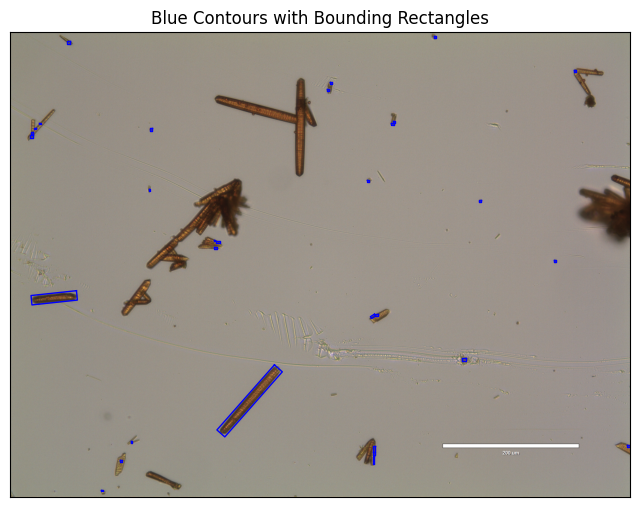

In [14]:
from co_mof import process_blue_contours  # TODO: vague function name
blue_areas, blue_aspect_ratios = process_blue_contours(image_gray, image, blue_contours)

# Histogram Analysis of Blue Contour Properties

This script analyzes the **areas** and **aspect ratios** of blue contours using histograms and statistical measures.

### Steps:
1. **Plot Histograms**:  
   - Displays **top** and **bottom histograms** for contour areas and aspect ratios.
   - Fits a **peak curve** to highlight the most common values.
2. **Compute Statistics**:  
   - Extracts **peak values**, **mean**, and **standard deviation** for both:
     - **Area**
     - **Aspect Ratio**
3. **Output Results**:  
   - Prints the computed statistical values.


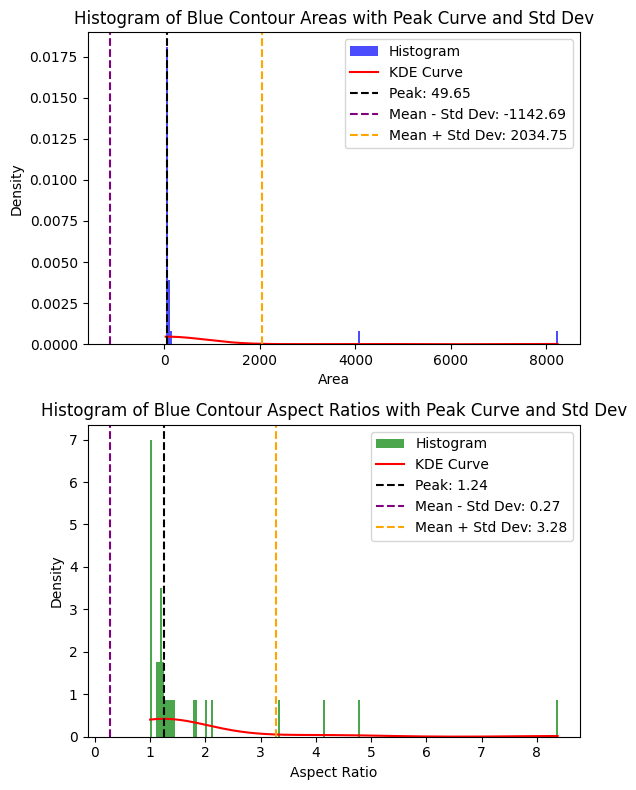

Peak Area: 49.648648648648646
Mean Area: 446.03225806451616, Std Dev Area: 1588.722726653466
Peak Aspect Ratio: 1.243628993192652
Mean Aspect Ratio: 1.7769680510696024, Std Dev Aspect Ratio: 1.5038553697991397


In [16]:
from co_mof import plot_top_bottom_histograms_with_peak_curve_and_std
# Example usage:
peak_area, peak_ar, mean_area, std_area, mean_ar, std_ar = plot_top_bottom_histograms_with_peak_curve_and_std(blue_areas, blue_aspect_ratios)

# Print the peaks and standard deviations  # TODO: should be in function
print(f"Peak Area: {peak_area}")
print(f"Mean Area: {mean_area}, Std Dev Area: {std_area}")
print(f"Peak Aspect Ratio: {peak_ar}")
print(f"Mean Aspect Ratio: {mean_ar}, Std Dev Aspect Ratio: {std_ar}")

## Overlaying Isolated Crystals on the Original Image

This script filters and overlays contours based on statistical analysis of **blue contour areas**.

### Steps:
1. **Analyze Histogram Data**:  
   - Extracts **peak area**, **mean area**, **standard deviation**, and **mean aspect ratio** from histogram analysis.
2. **Adjust Mean Area Threshold** *(Ensuring Most Contours Are Detected)*:  
   - If `mean_area > 5000`, it is adjusted to **500**.  
   - If `mean_area < 1000`, it is adjusted to **200**.
3. **Filter Contours**:  
   - Removes contours exceeding an upper limit derived from statistical values.
   - Outputs:
     - **Filtered Blue Contours** : Isolated Crystals
     - **Filtered Red Contours** : Clusters + Overlapping Crystals
4. **Overlay and Display**:  
   - Shows the processed contours on the original image.
5. **Output Results**:  
   - Prints the number of filtered contours and their areas (scaled by `length_per_pixel`).



## Filtering and Overlaying Contours with Area Limits

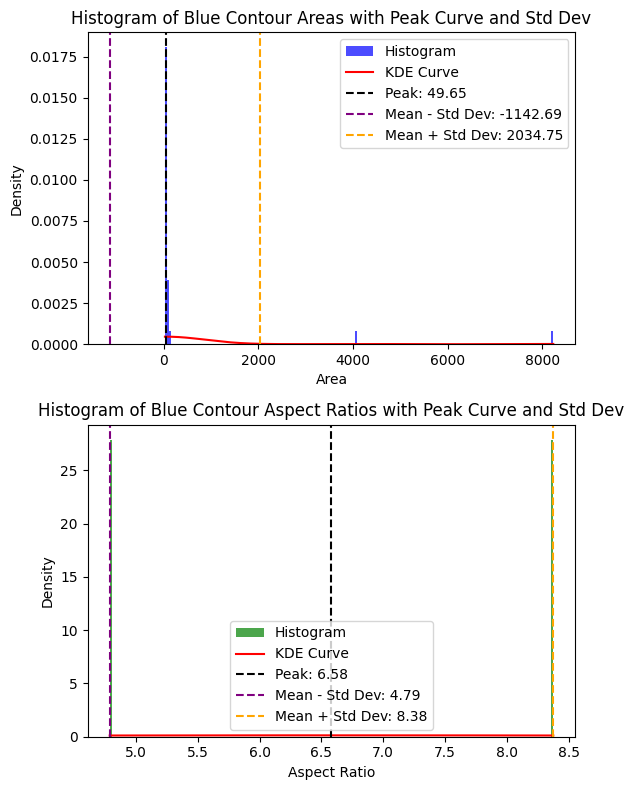

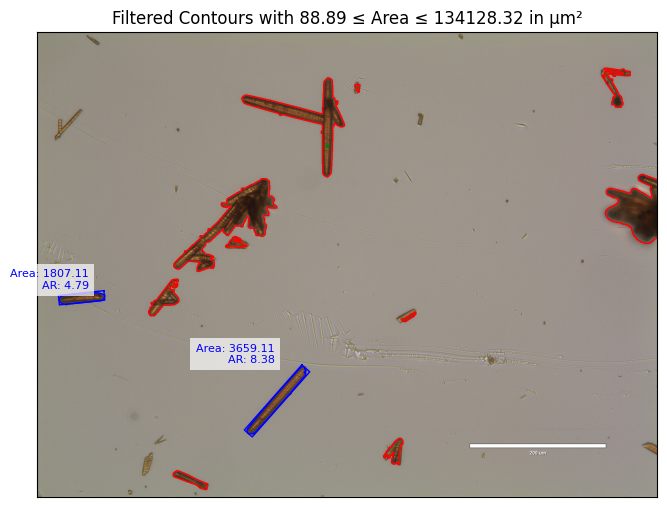

Number of Filtered Blue Contours: 2
Number of Red contours: 11
Number of Green contours: 1
Filtered Blue Contour Areas:
Contour 1: Area = 1807.111111111111
Contour 2: Area = 3659.111111111111


In [28]:
from co_mof import filter_and_overlay_all_contours_with_upper_limit

# Example usage:
# Assuming `areas`, `original_image`, `image_gray`, `blue_contours`, `red_contours`, and `green_contours` are defined
peak_area, _, mean_area, std_dev_area, mean_ar, _ = plot_top_bottom_histograms_with_peak_curve_and_std(
    blue_areas, blue_aspect_ratios
)

# TODO: put below in function
# Replacement of Value (To ensure most contours are detected)
if mean_area > 5000:
    mean_area = 500
            
elif mean_area < 1000:
    mean_area = 200

filtered_blue_contours, blue_contour_areas, filtered_red_contours, filtered_green_contours, blue_aspect_ratios = filter_and_overlay_all_contours_with_upper_limit(
    image, image_gray, blue_contours, red_contours, green_contours, mean_area, std_dev_area, peak_area, length_per_pixel
)

print(f"Number of Filtered Blue Contours: {len(filtered_blue_contours)}")
print(f"Number of Red contours: {len(filtered_red_contours)}")
print(f"Number of Green contours: {len(filtered_green_contours)}")

actual_blue_contour_areas = []

# Print the areas of filtered blue contours
print("Filtered Blue Contour Areas:")
for idx, blue_contour_area in enumerate(blue_contour_areas):
    blue_contour_area = blue_contour_area * length_per_pixel
    actual_blue_contour_areas.append(blue_contour_area)
    print(f"Contour {idx + 1}: Area = {blue_contour_area}")

## Removing Edge-Touching Red Contours

This script filters out **red contours** that touch the image edges before further processing.

### Steps:
1. **Detect Edge-Touching Contours**:  
   - Identifies **red contours** that intersect with the image boundary.
2. **Remove Edge Contours**:  
   - Filters out these contours to avoid boundary artifacts.
3. **Display Results**:  
   - Overlays the remaining ** filtered red contours** on the original image for visualization.

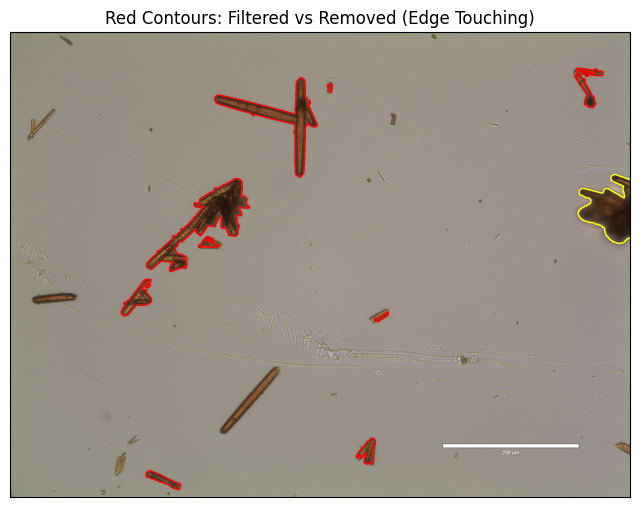

In [29]:
from co_mof import remove_edge_touching_contours_and_display

# Remove and display red contours that touch the edges before filtering
clusters = remove_edge_touching_contours_and_display(filtered_red_contours, image_gray, image, color="red")

## Bounding Box Analysis and Contour Area Calculation

This script calculates the **areas of red clusters** and overlays their bounding boxes on the image.

### Steps:
1. **Draw Bounding Boxes**:  
   - Plots bounding boxes around **Overlapping Crystals and Clusters**.
2. **Calculate Contour Areas**:  
   - Computes area for each red contour, scaled using `length_per_pixel`.
3. **Output Results**:  
   - Prints the calculated contour areas in **µm²**.


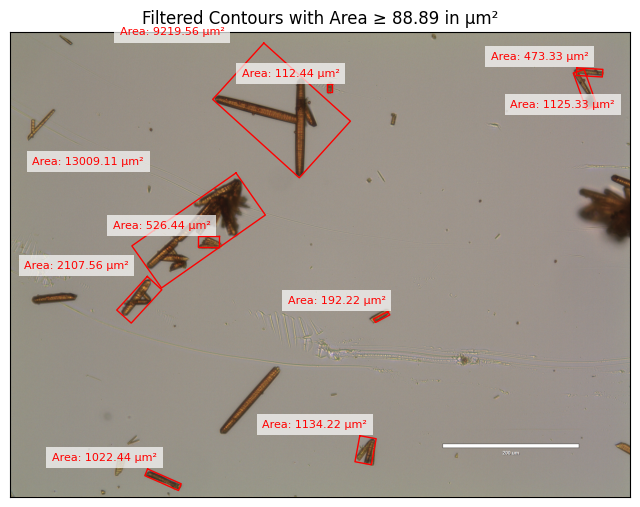

Actual Contour Areas for Filtered Red Contours:
Contour 1: Area = 473.33 µm²
Contour 2: Area = 1125.33 µm²
Contour 3: Area = 9219.56 µm²
Contour 4: Area = 112.44 µm²
Contour 5: Area = 13009.11 µm²
Contour 6: Area = 526.44 µm²
Contour 7: Area = 2107.56 µm²
Contour 8: Area = 192.22 µm²
Contour 9: Area = 1134.22 µm²
Contour 10: Area = 1022.44 µm²


In [32]:
from co_mof import plot_bounding_boxes_and_calculate_contour_area

clusters_areas = plot_bounding_boxes_and_calculate_contour_area(
    clusters, image, mean_area, length_per_pixel, color="red"
)

# Print the calculated contour areas
print("Actual Contour Areas for Filtered Red Contours:")
for idx, area in enumerate(clusters_areas):
    print(f"Contour {idx + 1}: Area = {area:.2f} µm²")

## Data Analysis

## Might Remove it (Arthur)

In [33]:
from co_mof import create_summary_table

# Example Data
# Generate the summary table
summary_table = create_summary_table(
    blue_aspect_ratios, 
    actual_blue_contour_areas, clusters_areas
)

# Display the summary table
display(summary_table)

,Category,Count,Mean Aspect Ratio,Mean Area (µm²)
0,Single Crystals,2,6.58,2733.11
1,Clusters,10,-,2892.27


In [16]:
# TODO: confused about this - it is a duplicate function and uses styling that requires extra dependencies

# import pandas as pd
# from IPython.display import display

# def create_summary_table(
#     aspect_ratios_single,
#     areas_single, areas_clusters
# ):
#     """
#     Create a summary table with the count of contours, mean aspect ratios, and mean areas for single crystals,
#     overlapping crystals, and clusters.

#     Parameters:
#     - single_crystals: List of single crystals.
#     - overlapping_crystals: List of overlapping crystals.
#     - clusters: List of clusters.
#     - aspect_ratios_single: List of aspect ratios for single crystals.
#     - aspect_ratios_overlapping: List of aspect ratios for overlapping crystals.
#     - aspect_ratios_clusters: List of aspect ratios for clusters.
#     - areas_single: List of areas for single crystals.
#     - areas_overlapping: List of areas for overlapping crystals.
#     - areas_clusters: List of areas for clusters.

#     Returns:
#     - summary_table: Pandas DataFrame containing the summary.
#     """
#     # Calculate counts
#     count_single_crystals = len(aspect_ratios_single)
#     count_clusters = len(areas_clusters)

#     # Calculate mean aspect ratios
#     mean_ar_single = round(np.mean(aspect_ratios_single), 2) if aspect_ratios_single else 0
#     mean_ar_clusters = "-"

#     # Calculate mean areas
#     mean_area_single = round(np.mean(areas_single), 2) if areas_single else 0
#     mean_area_clusters = round(np.mean(areas_clusters), 2) if areas_clusters else 0

#     # Calculate totals
#     total_count = count_single_crystals 
#     total_aspect_ratios = aspect_ratios_single 
#     total_mean_ar = round(np.mean(total_aspect_ratios), 2) if total_aspect_ratios else 0


#     # Create the summary table
#     summary_table = pd.DataFrame({
#         "Category": ["Single Crystals", "Overlapping Crystals", "Total", "Clusters"],
#         "Count": [count_single_crystals, count_clusters],
#         "Mean Aspect Ratio": [mean_ar_single,   mean_ar_clusters],
#         "Mean Area (µm²)": [mean_area_single, mean_area_clusters]
#     })

#     return summary_table

# # Example Data
# # Generate the summary table

# # Format specific columns to 2 decimal points
# summary_table["Mean Aspect Ratio"] = summary_table["Mean Aspect Ratio"].apply(
#     lambda x: f"{float(x):.2f}" if isinstance(x, (int, float)) else x
# )
# summary_table["Mean Area (µm²)"] = summary_table["Mean Area (µm²)"].apply(
#     lambda x: f"{float(x):.2f}" if isinstance(x, (int, float)) else x
# )

# # Display the summary table with Arial font styling and centering
# styled_table = summary_table.style.set_table_styles([
#     {'selector': 'th', 'props': [('font-family', 'Arial'), ('font-size', '12px'), ('text-align', 'center')]},
#     {'selector': 'td', 'props': [('font-family', 'Arial'), ('font-size', '12px'), ('text-align', 'center')]},
#     {'selector': 'table', 'props': [('margin-left', 'auto'), ('margin-right', 'auto')]}  # Center the table
# ])
# display(styled_table)

In [43]:
from co_mof import calculate_summary_with_std

# Calculate summary table with standard deviations
summary_table_with_std = calculate_summary_with_std(
    blue_aspect_ratios,
    actual_blue_contour_areas, clusters_areas
)

# Ensure the plot displays the categories in the correct order
correct_order = ["Isolated Crystals", "Clusters"]
summary_table_with_std = summary_table_with_std.iloc[::-1].reset_index(drop=True)

# Update category labels to have one word per line
summary_table_with_std["Category"] = summary_table_with_std["Category"].replace({
    "Single Crystals": "Single\nCrystals",
    "Clusters": "Clusters"
})

# # Define bar width
# bar_width = 0.5  # Adjust this value for the desired bar width

# # Plot horizontal bar plot for counts
# plt.figure(figsize=(5, 4))
# plt.barh(summary_table_with_std["Category"], summary_table_with_std["Count"], color='dodgerblue', height=bar_width)
# plt.xlabel("Count", fontsize=14)
# # plt.ylabel("Category", fontsize=14)
# # plt.title("Counts of Crystals and Clusters", fontsize=16)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

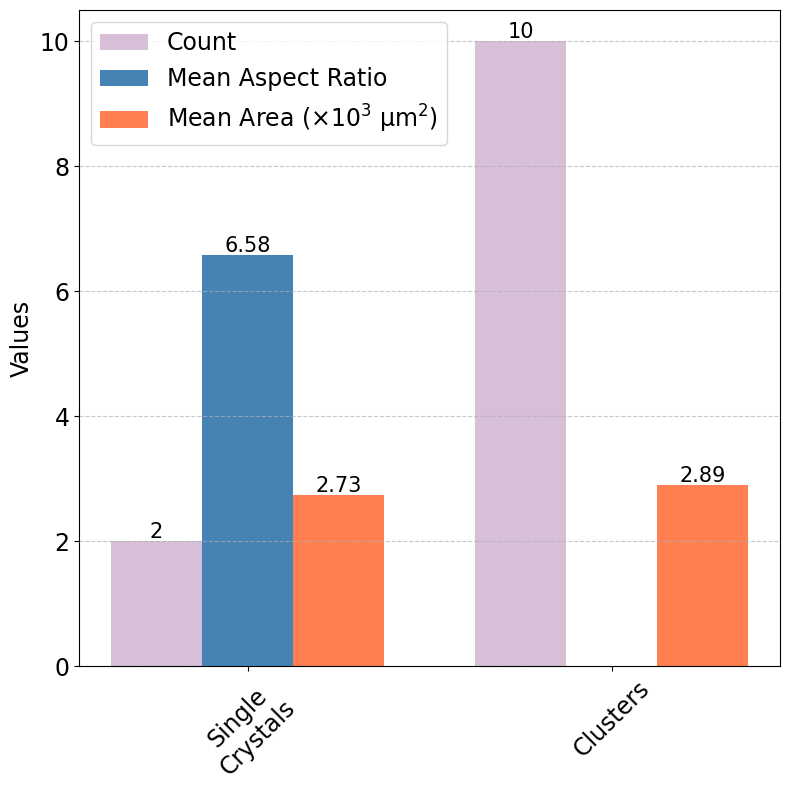

In [40]:
# TODO: should be in a function
from matplotlib import pyplot as plt

# Extract data from the summary table
categories = summary_table_with_std["Category"][::-1]
counts = summary_table_with_std["Count"][::-1]
mean_aspect_ratios = summary_table_with_std["Mean Aspect Ratio"][::-1]
mean_areas = summary_table_with_std["Mean Area (µm²)"][::-1]

# Define bar positions and width
bar_width = 0.25
indices = np.arange(len(categories))

# Convert Mean Aspect Ratio and Mean Area to floats, handling non-numeric values like "-"
mean_aspect_ratios = [float(val) if val != "-" else 0 for val in mean_aspect_ratios]
mean_areas = [float(val) if val != "-" else 0 for val in mean_areas]

# Normalize Mean Area for better visualization alongside Count and Aspect Ratio
area_scaling_factor = 1e3  # Adjust this for better scaling
mean_areas_scaled = [area / area_scaling_factor for area in mean_areas]

# Plot grouped vertical bar chart
fig, ax = plt.subplots(figsize=(8, 8))

# Add bars for Count
bars_count = plt.bar(indices - bar_width, counts, width=bar_width, color='thistle', label='Count')

# Add bars for Mean Aspect Ratio
bars_aspect = plt.bar(indices, mean_aspect_ratios, width=bar_width, color='steelblue', label='Mean Aspect Ratio')

# Add bars for Mean Area (scaled)
bars_area = plt.bar(indices + bar_width, mean_areas_scaled, width=bar_width, color='coral', label=r"Mean Area ($\times10^3$ µm$^2$)")


for bars, data in zip([bars_count, bars_aspect, bars_area], [counts, mean_aspect_ratios, mean_areas_scaled]):
    for bar, value in zip(bars, data):
        if value != 0:  # Ignore labels for bars with a value of 0
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # Center the text horizontally on the bar
                bar.get_height() + 0.05,  # Position slightly above the bar
                f"{value:.2f}" if isinstance(value, float) else f"{int(value)}",  # Format the text
                ha='center', fontsize=15
            )

# Add labels and legend
plt.ylabel("Values", fontsize=17)
plt.xticks(indices, categories, fontsize=17, rotation=45)
plt.yticks(fontsize=17)
plt.legend(fontsize=17, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a title
# plt.title("Counts, Aspect Ratios, and Areas by Category", fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
## if no blue contour then print print there are bno single crystals detected 